### __Solving ODE using NN__

In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNet(nn.Module):
    def __init__(self, hidden_size, output_size=1,input_size=1):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.LeakyReLU()
        self.l4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l4(out)
        return out

In [2]:
# Create the criterion that will be used for the DE part of the loss
criterion = nn.MSELoss()

# Define the loss function for the initial condition
def initial_condition_loss(y, target_value):
    return nn.MSELoss()(y, target_value)

In [7]:
# Time vector that will be used as input of our NN
t_numpy = np.arange(0, 5+0.01, 0.01, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)

# Constant for the model
k = 1
def f(y):
    return -k * y

# Instantiate one model with 50 neurons on the hidden layers
model = NeuralNet(hidden_size=50)

# Loss and optimizer
learning_rate = 8e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = int(100)

In [4]:
for epoch in range(num_epochs):

    # Randomly perturbing the training points to have a wider range of times
    # epsilon = torch.normal(0,0.1, size=(len(t),1)).float()
    # t_train = t + epsilon
    t_train = t

    # Forward pass
    y_pred = model(t_train)

    # Calculate the derivative of the forward pass w.r.t. the input (t)
    dy_dt = torch.autograd.grad(y_pred, 
                                t_train, 
                                grad_outputs=torch.ones_like(y_pred), 
                                create_graph=True)[0]

    # Define the differential equation and calculate the loss
    loss_DE = criterion(dy_dt - f(y_pred), torch.zeros_like(dy_dt))

    # Define the initial condition loss
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])), 
                                     torch.tensor([[1.0]]))

    loss = loss_DE + loss_IC

    # Backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

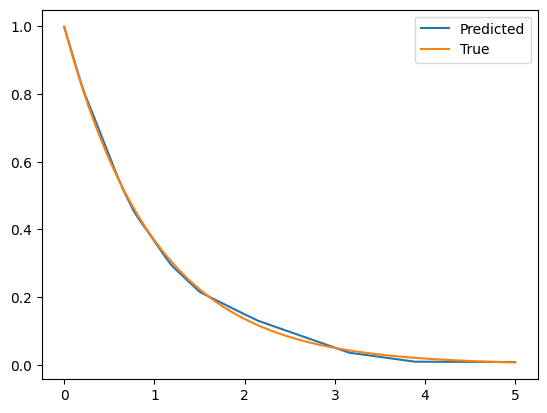

In [5]:
# Visualize the results
import matplotlib.pyplot as plt
plt.plot(t_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), label='Predicted')
plt.plot(t_train.cpu().detach().numpy(), torch.exp(-t_train).cpu().detach().numpy(), label='True')
plt.legend()
plt.show()
